# Machine Learning: Week 12

## K-means, clustering

This week we talked about clustering. In this workshop, we are going to examine some properties of different clustering algorithms. The first part of the workshop is going the look into the details of **k-means**, and after that we are going to compare the properties of different approaches: **k-means**, **Gaussian Mixture models** (a more advanced version of _k-Gaussians_ introduced in the lecture), and **agglomerative clustering** (a type of hierarchical clustering).

We will go over the notebook together in the workshop. It contains several solved examples and some **exercises where you need to add some code**. If something does not run it might mean you need to alter or add a statement :) Also, **make sure you run all the code cells** (even the ones with examples) to ensure the rest of the notebook runs as intended.

We cover this through the following topics:
- [K-means](#K-means)
    - [Within-cluster-scatter](#Within-cluster-scatter)
        - [Exercise 1](#Exercise-1)
        - [Exercise 2](#Exercise-2)
    - [Representative sample of a cluster](#Representative-sample-of-a-cluster)
        - [Exercise 3](#Exercise-3)
        - [Exercise 4](#Exercise-4)
    - [Model evaluation](#Model-evaluation)
        - [Exercise 5](#Exercise-5)
- [Failure cases and alternative methods](#Failure-cases-and-alternative-methods)
    - [Exercise 6](#Exercise-6)
        - [Exercise 6a](#Exercise-6a)
        - [Exercise 6b](#Exercise-6b)
        - [Exercise 6c](#Exercise-6c)
        - [Exercise 6d](#Exercise-6d)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(12345)

plt.rcParams.update({'font.size': 16})

## K-means

First, we will look into some details of K-means. For this, we will use a combination of generated/toy datasets, and a [handwritten digit dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).

### Within-cluster-scatter

The first step in clustering is to get some measure of "coherence" of our cluster. **Within-cluster scatter** answers the question of _how scattered/bunched up_ a cluster is. First, let us generate some data from a slightly skewed 2-D Gaussian distribution.

_Note: If you can't notice the slight slant in the data, try changing the number of generated points (with more points it should be more obivious)._

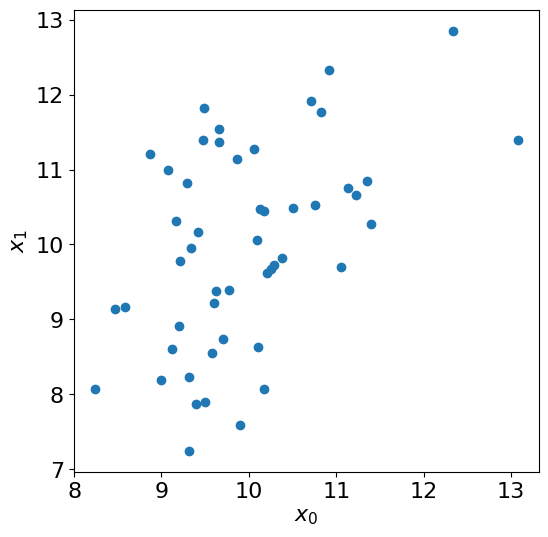

In [14]:
cov = [[1, 0.7],
       [0.7, 2]]

# To increase number of data points change 50 to something else:
X = rng.multivariate_normal([10, 10], cov, 50)

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(X[:, 0], X[:, 1])
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
plt.show()

#### Exercise 1

Find the mean of all the samples. As a reminder, if we have a collection $\mathbf{x} = \{\mathbf{x}_i\} \forall i=1..M$ of M nD samples $\mathbf{x}_i = (x_{1,i}, x_{2,i}, \dots, x_{n,i})$.

The general formula for the mean of M samples is:

\begin{equation*}
    \bar{\mathbf{x}} =
    \frac{1}{M}\sum_{i=1}^M{\mathbf{x}_i}
\end{equation*}

This means we calculate the mean component-by-component:

\begin{equation*}
    \bar{\mathbf{x}} =
    \begin{bmatrix}
        \frac{1}{M}\sum_{i=1}^M{\mathbf{x}_{0,i}} \\
        \frac{1}{M}\sum_{i=1}^M{\mathbf{x}_{1,i}} \\
        \dots \\
        \frac{1}{M}\sum_{i=1}^M{\mathbf{x}_{n,i}} \\
    \end{bmatrix}.
\end{equation*}

To calculate this, you can use the [`numpy.mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) function with the **correct choice of `axis` parameter**. If you have done this correctly, you should obtain the below image, showing the mean as a green cross.

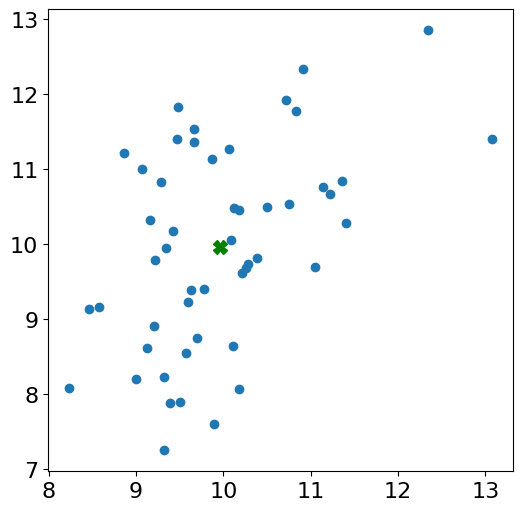

array([9.96016248, 9.96049057])

In [47]:
def find_mean(X):
    # Use first dimension axis to find mean, also known as the column mean
    # where as axis=1 takes the row wise mean.
    # we want the column mean because we want the mean of each feature
    return np.mean(X, axis=0)
    
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[:, 0], X[:, 1])
meanX = find_mean(X)
ax.plot(meanX[0], meanX[1], 'gX', ms=10)
plt.show()

#### Exercise 2

The next step is calculating the within-cluster-scatter. As a reminder, the WCS is equal to the sum of squared Euclidean distances from each data point to the closest cluster centre. For a _single_ cluster (or a whole dataset), it will simply be equal to the distance between every point and the dataset _mean_.

Single-cluster within-cluster-scatter:

$$
SW = \sum_{i=1..N}{d(\mathbf{x}_i, \bar{\mathbf{x}})}.
$$

The squared Euclidean distance between two samples $\mathbf{x}_1$ and $\mathbf{x}_2$ with components $\mathbf{x}_1=(x_{1,1}, x_{1,2}, ... x_{1,d})$ and $\mathbf{x}_2=(x_{2,1}, x_{2,2}, ... x_{2,d})$:

$$
d(\mathbf{x}_1, \mathbf{x}_2) = \sum_{q=1..d}{(x_{1,q}-x_{2,q})^2}.
$$

Write a function that calculates within-cluster-scatter _for a single cluster:_

In [27]:
def single_within_cluster_scatter(X):
    dataset_mean = find_mean(X)
    
    return np.sum((X - dataset_mean)**2)
    
print(single_within_cluster_scatter(X))

132.23918613909967


### Representative sample of a cluster

To better understand what is meant by "representative sample", let us work with a dataset we can examine _visually_: a dataset of handwritten digits we can load through sklearn.

The data points in this dataset represent the gray levels in a grayscale image of the size 8x8 pixels. This means that every data point has 64 features, which we can represent visually. Let us examine the dataset before running clustering on it:

In [32]:
from sklearn.datasets import load_digits
digits = load_digits()

print(digits.data[7])
print(digits.data.shape)

[ 0.  0.  7.  8. 13. 16. 15.  1.  0.  0.  7.  7.  4. 11. 12.  0.  0.  0.
  0.  0.  8. 13.  1.  0.  0.  4.  8.  8. 15. 15.  6.  0.  0.  2. 11. 15.
 15.  4.  0.  0.  0.  0.  0. 16.  5.  0.  0.  0.  0.  0.  9. 15.  1.  0.
  0.  0.  0.  0. 13.  5.  0.  0.  0.  0.]
(1797, 64)


array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In addition to inspecting the (numerical) values of the samples and features, we can also display some of the samples in this dataset. Let us display 9 random samples:

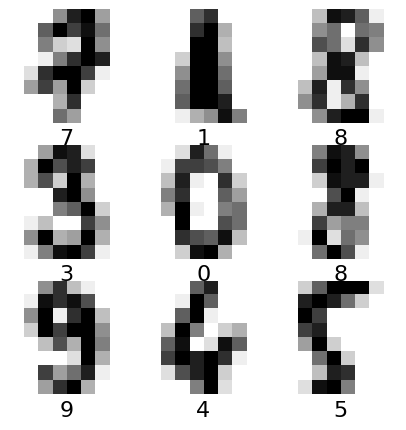

In [31]:
fig, axs = plt.subplots(3, 3, figsize=(5, 5))

for sample, ax in zip(rng.integers(0, digits.data.shape[0], 9), axs.flat):
    ax.set(xticks=[], yticks=[])
    [s.set_visible(False) for s in ax.spines.values()]
    ax.set_xlabel(digits.target[sample])
    ax.imshow(digits.images[sample], cmap=plt.cm.binary)

#### Exercise 3

Using the `find_mean()` function you wrote for [Exercise 1](#Exercise-1), in combination with [`numpy.reshape()`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) function which you can use to reshape the dimensions of an array (e.g. to transforms a 1x64 set of features into a 8x8 image), calculate the mean of this dataset and display it:

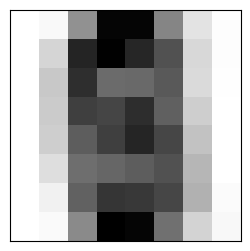

In [52]:
# We want to calculate the mean for each pixel so mean for each column, which returns a 1x64 array,
# and then reshape it to 8x8 so we can plot it
mean_digit = np.reshape(np.mean(digits.data, axis=0), (8, 8))
# 64 --> 8x8 
# 64 --> 7x10
# 64 --> 8x?
# 64 --> ?x8


fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(mean_digit, cmap = plt.cm.binary)
ax.set(xticks=[], yticks=[])
plt.show()


Now, let us cluster this data into 10 clusters and examine the value of cluster centres (rather than the whole dataset mean).

To fit model to the data, you can use the `fit()` method. As KMeans is a clustering approach, we have some different functions/attributes we can use to access the results (rather than just `predict()` method).

For example, `KMeans.cluster_centres_` attribute can be used to access the cluster centres (which have same number of features as the input samples, but there are only K of them):

In [55]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=10, random_state=0, n_init = 10)
model.fit(digits.data)

model.cluster_centers_.shape

(10, 64)

If we display the cluster centres, we can see that many of the digits are recognisable. This is because every cluster centre can be seen as a "representative" sample of it's cluster.

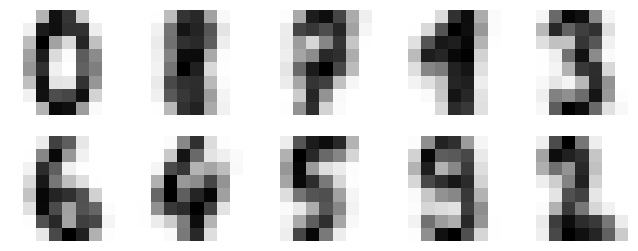

In [54]:
fig, axs = plt.subplots(2, 5, figsize=(8, 3))
centers = model.cluster_centers_.reshape(-1, 8, 8)
for ax, center in zip(axs.flat, centers):
    ax.set(xticks=[], yticks=[])
    [s.set_visible(False) for s in ax.spines.values()]
    ax.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

#### Exercise 4

Within-cluster-scatter of a specific clustering. Once we have fit the model to the data, we can actually access the within-cluster-scatter through the `KMeans.inertia_` attribute.

However, for this exercise, try to compute it by hand. This will mean calculating the single within cluster scatter (using the function implemented in [Exercise 2](#Exercise-2)) for every cluster returned by KMeans, and summing those up. To access the cluster labels predicted by K-means, you can use `KMeans.labels_` attribute (or, `KMeans.predict()` function:

In [62]:
cluster_labels = model.labels_

WCS_clusters = 0

# for each label found by the clustering
# select the cluster assigned to that label (all the data points with that label)
# calculate single WCS for the selected cluster

######################################################
### YOUR SOLUTION - LIKELY IN THE FORM OF A FOR LOOP #
######################################################
cluster_count = model.cluster_centers_.shape[0]

for cluster_count in range(0, cluster_count):
    cluster = digits.data[cluster_labels == cluster_count]
    wcs_for_cluster = single_within_cluster_scatter(cluster)
    print(f"The WCS for cluster with label {cluster_count} is: {wcs_for_cluster}")
    WCS_clusters += wcs_for_cluster  # sum single WCS into total WCS

print(WCS_clusters)
print(model.inertia_)
print("The difference is {}".format(single_within_cluster_scatter(digits.data)-WCS_clusters))


The WCS for cluster with label 0 is: 71010.37640449438
The WCS for cluster with label 1 is: 159351.47085201793
The WCS for cluster with label 2 is: 158616.8076923077
The WCS for cluster with label 3 is: 60990.02298850575
The WCS for cluster with label 4 is: 109828.202247191
The WCS for cluster with label 5 is: 91951.28571428571
The WCS for cluster with label 6 is: 113521.2899408284
The WCS for cluster with label 7 is: 106778.04
The WCS for cluster with label 8 is: 169863.36032388665
The WCS for cluster with label 9 is: 123278.03428571428
1165188.890449232
1165188.890449232
The difference is 993868.4005913911


array([0, 1, 1, ..., 1, 8, 8])

### Model evaluation

The within-cluster-scatter is used for model evaluation in K-Means. However, we can not simply pick the clustering with the smallest WCS - as we can always get WCS to be equal zero if the number of clusters is equal to the number of data points in the cluster.

Instead, we can try clustering the data with different values of K and plot the WCS for different values of K. An "elbow" in this graph (the bottom of steep hill) is likely the best K-value.

The below cell does this for the digits dataset, for all values of K between 2 and 30. Let us check the results (careful, this cell takes a while to execute):

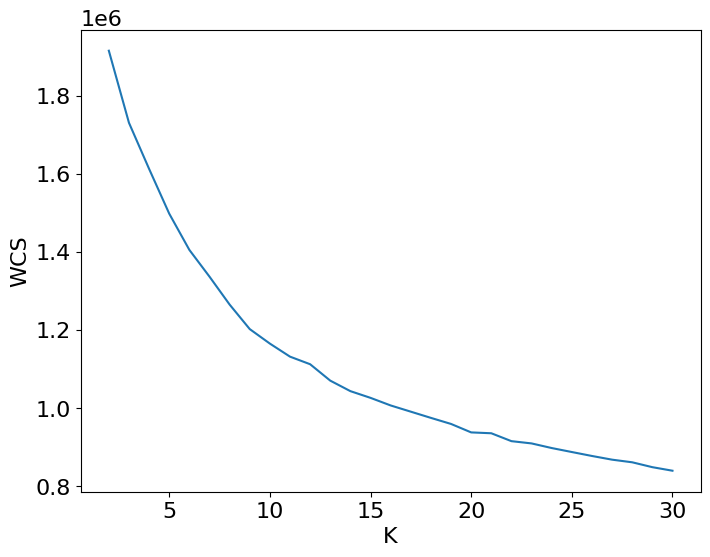

In [11]:
# 30+ seconds

WCS = []
maxk = 30
for k in range(2, maxk+1):
    model = KMeans(n_clusters=k, random_state=0, n_init=10)
    model.fit(digits.data)
    WCS.append(model.inertia_)
    
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range(2, maxk+1), WCS)
ax.set_xlabel("K")
ax.set_ylabel("WCS")
plt.show()

#### Exercise 5

The "elbow" from the above method of model evaluation gets sharper and more pronounced the "clearer" our clusters are.

We can show this by clustering some generated data. Sklearn provides a `make_blobs()` function we can use to generate some fake clusters. K-Means produces a pretty good solution on them -- this fake dataset is displayed in the first code cell below (the task is explained below this cell).

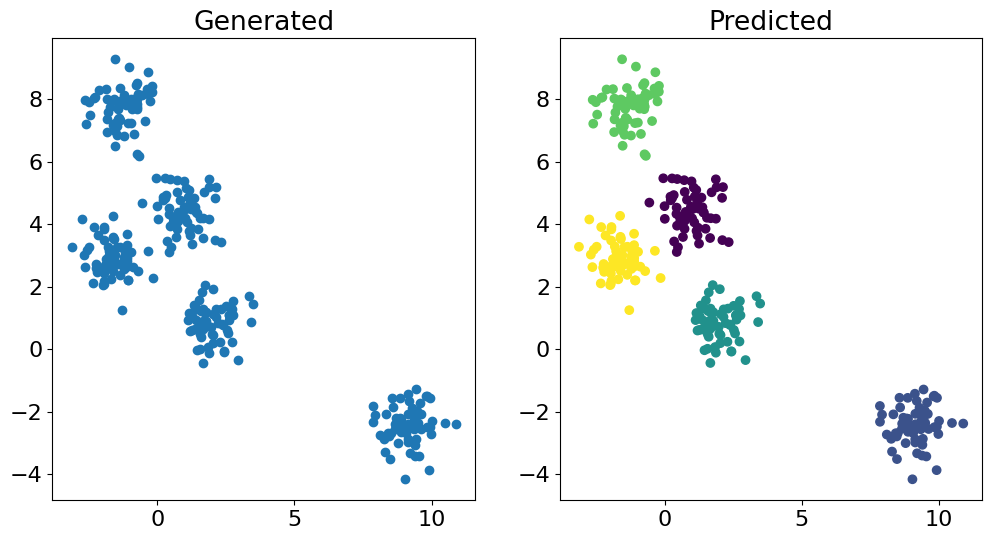

In [21]:
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=300, centers=5, cluster_std=0.60, random_state=0)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#print(X)
ax[0].scatter(X[:, 0], X[:, 1])
ax[0].set_title("Generated")

model = KMeans(n_clusters = 5, n_init=10)
model.fit(X)

ax[1].scatter(X[:, 0], X[:, 1], c=model.labels_)
ax[1].set_title("Predicted")
plt.show()

In this second code cell, add code to plot the value of WCS against different values of K between 2 and 30. **Is the "elbow" sharper in this example? Change the number of blobs in the dataset in the previous cell and look at the effect on the "elbow" in the next cell.**

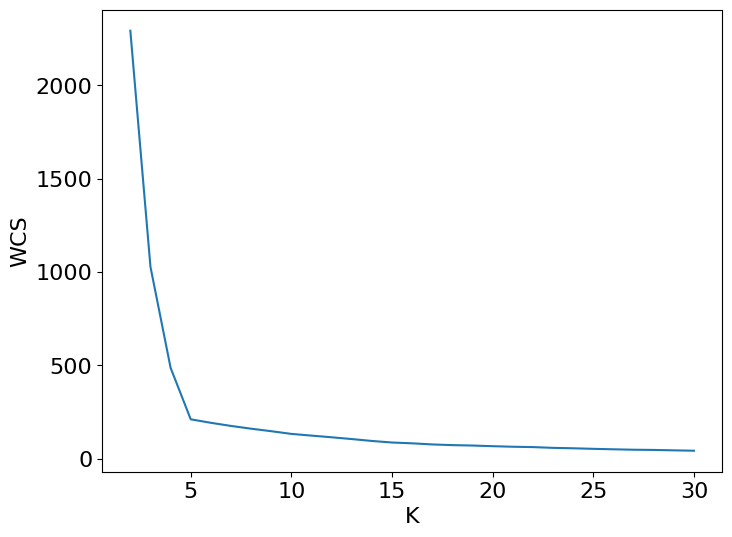

In [22]:
WCS = []
maxk = 30

# plot WCS against different value of k
for k in range(2, maxk+1):
    pass # add your code here
    
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(2, maxk+1), WCS)
ax.set_xlabel("K")
ax.set_ylabel("WCS")
plt.show()

## Failure cases and alternative methods

In this part of the workshop, we will look into the failure cases of KMeans, and some alternative clustering algorithms.

The algorithms we will be looking at, and their properties, are as follows:

| Algorithm      | Description |
| ----------- | ----------- |
| KMeans      | Partitional clustering. Requires normalised data, in effect assumes a normal distribution with variance=1 for every cluster (and an unknown mean) |
| Gaussian Mixture Models   | Partitional clustering. Similar to KMeans, assumes all clusters come from a normal distribution, but with an unknown variance and mean  |
| Agglomerative - Complete linkage   | Hierarchical clustering. Complete linkage causes small, compact clusters, and long computation times  |
| Agglomerative - Average linkage   | Hierarchical clustering. Average linkage should lead to balanced clusters, but still requires long computation.  |
| Agglomerative - Single linkage   | Hierarchical clustering. Single linkage leads to large, loose clusters, but should allow for a more efficient implementation  |

As an example of how to use these algorithms, let us show-case how they work on a toy blobs dataset, which is successfully clustered by all 5 approaches. Here, we are using the `fit_predict()` method of all these algorithms, to fit the model to the data and _predict_ the clusters of the training data in the same step.

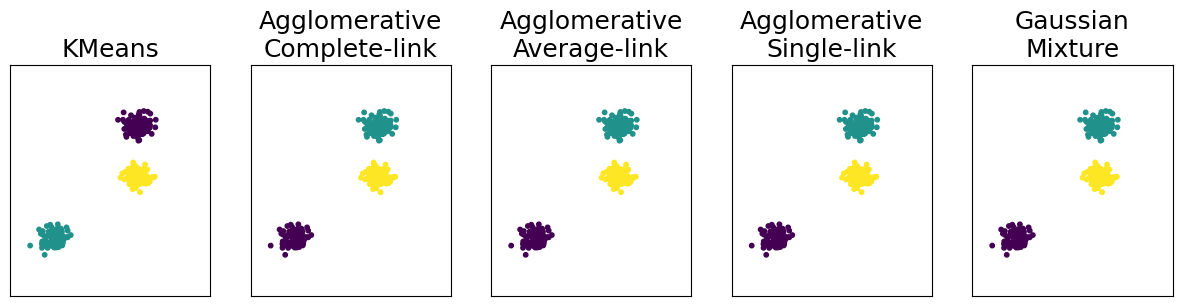

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

X, _ = make_blobs(n_samples=300, centers = 3, random_state=8)

#my_scaler = StandardScaler()
#my_scaler.fit(X)
#X = my_scaler.transform(X)
#X = my_scaler.inverse_transform(X)

# normalize the data
X = StandardScaler().fit_transform(X)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

k_means = KMeans(n_clusters = 3, n_init=10)
complete = AgglomerativeClustering(n_clusters = 3, linkage="complete")
average = AgglomerativeClustering(n_clusters = 3, linkage="average")
single = AgglomerativeClustering(n_clusters = 3, linkage="single")
gmm = GaussianMixture(n_components = 3, covariance_type="full")

clustering_algorithms = (
    ("KMeans", k_means),
    ("Agglomerative\nComplete-link", complete),
    ("Agglomerative\nAverage-link", average),
    ("Agglomerative\nSingle-link", single),
    ("Gaussian\nMixture", gmm),
)

for (name, algo), ax in zip(clustering_algorithms, axs):        

        #algo.fit(X)
        #y_pred = algo.predict(X)
        y_pred = algo.fit_predict(X)
              
        ax.scatter(X[:, 0], X[:, 1], s=10, c=y_pred)
        
        ax.set_title(name, size=18)
        
        ax.set_xlim([-2.5, 2.5])
        ax.set_ylim([-2.5, 2.5])
        ax.set(xticks=[], yticks=[])

plt.show()

#### Exercise 6

This exercise showcases several failure cases of KMeans. Each of the examples prepares a toy dataset, and displays the generated labels as well as the labels obtaiend by KMeans (the order of the colours is not important, just the different groups obtained).

As you can see, KMeans does not work the best with this kind of data. For each of the following examples, **replace the KMeans** clustering with one of the above mentioned clustering methods, to obtain better results.

#### Exercise 6a

Clusters with different variances.

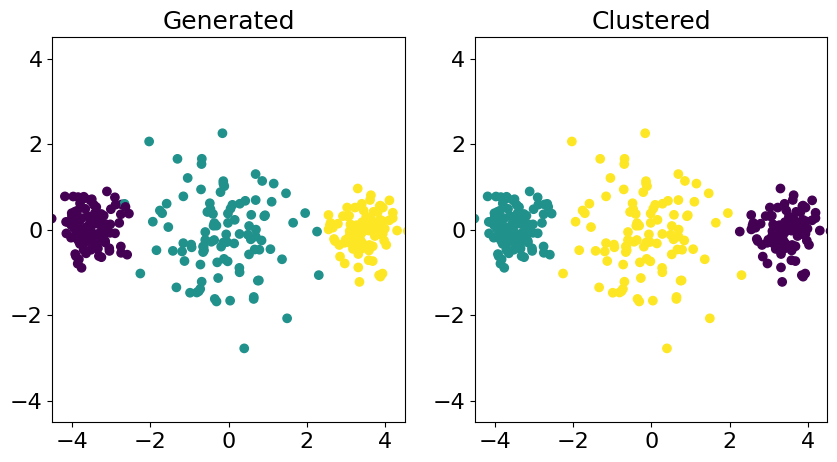

In [15]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, 
                  centers=[[-3.5, 0], [0,0], [3.5, 0]],
                  cluster_std=[0.4, 1.0, 0.4], random_state=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_xlim([-4.5, 4.5])
axs[0].set_ylim([-4.5, 4.5])
axs[0].scatter(X[:, 0], X[:, 1], c=y)
axs[0].set_title("Generated", size=18)


axs[1].set_xlim([-4.5, 4.5])
axs[1].set_ylim([-4.5, 4.5])

# replace these lines
model = KMeans(n_clusters = 3, n_init=10)
y_pred = model.fit_predict(X)

axs[1].scatter(X[:, 0], X[:, 1], c=y_pred)
axs[1].set_title("Clustered", size=18)
plt.show()

#### Exercise 6b

Overlapping clusters with different variances (another example)

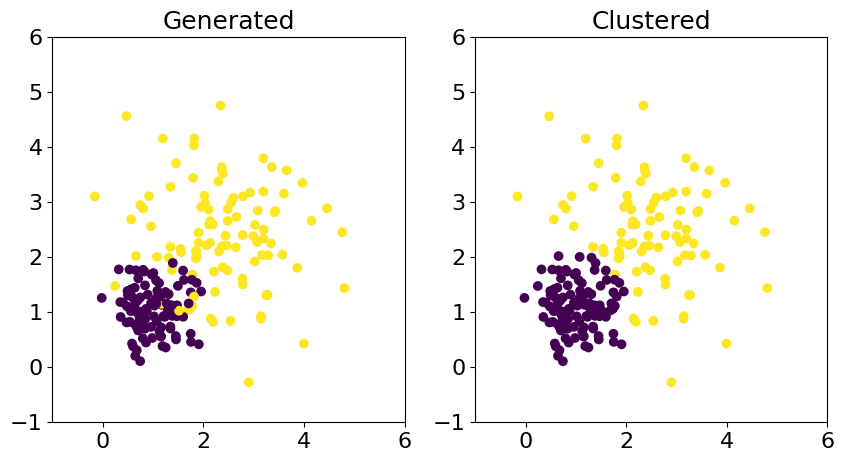

In [16]:
X, y = make_blobs(n_samples=200, 
                  centers=[[1,1], [2.5,2.5]],
                  cluster_std=[0.4, 1.], random_state=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_xlim([-1, 6])
axs[0].set_ylim([-1, 6])
axs[0].scatter(X[:, 0], X[:, 1], c=y)
axs[0].set_title("Generated", size=18)

axs[1].set_xlim([-1, 6])
axs[1].set_ylim([-1, 6])

# replace these lines
model = KMeans(n_clusters = 2, n_init=10)
y_pred = model.fit_predict(X)

axs[1].scatter(X[:, 0], X[:, 1], c=y_pred)
axs[1].set_title("Clustered", size=18)
plt.show()

#### Exercise 6c

Anisotropic (very very skewed) clusters.

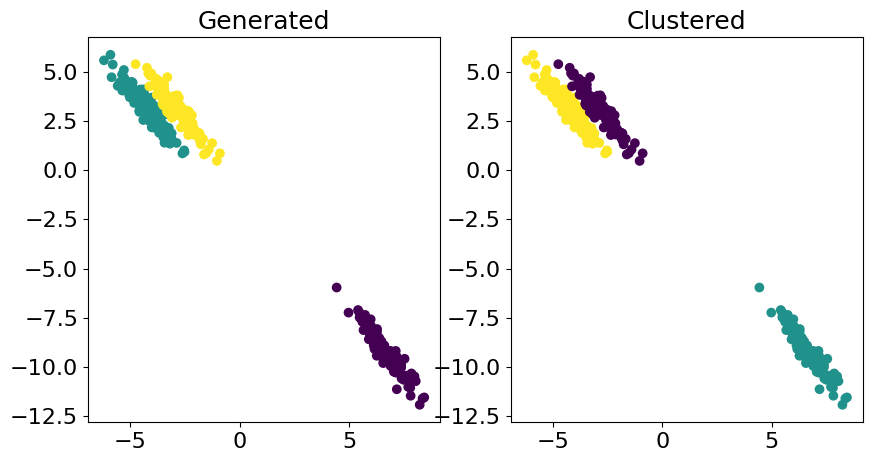

In [17]:
X, y = make_blobs(n_samples=400, random_state=15)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X = np.dot(X, transformation)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#axs[0].set_xlim([-8, 8])
#axs[0].set_ylim([-8, 8])
axs[0].scatter(X[:, 0], X[:, 1], c=y)
axs[0].set_title("Generated", size=18)


# replace the following line
model = KMeans(n_clusters = 3, n_init=10)
y_pred = model.fit_predict(X)

axs[1].scatter(X[:, 0], X[:, 1], c=y_pred)
axs[1].set_title("Clustered", size=18)
plt.show()

#### Exercise 6d

Nested clusters.

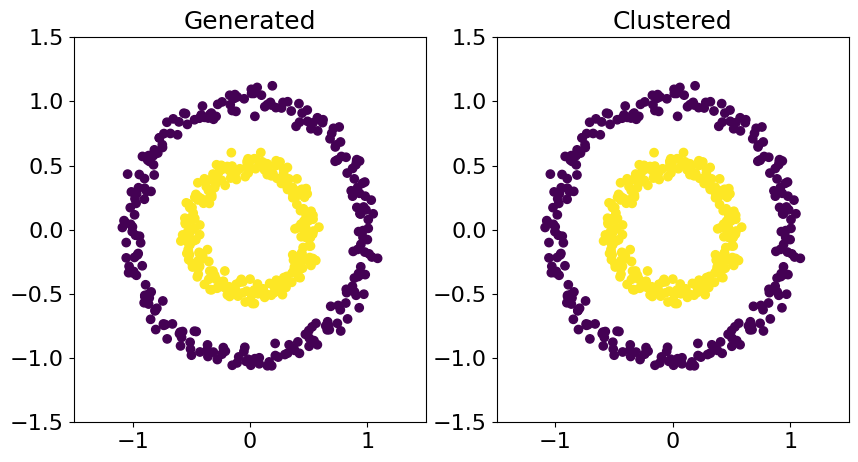

In [18]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=500, factor=0.5, noise=0.05)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_xlim([-1.5, 1.5])
axs[0].set_ylim([-1.5, 1.5])
axs[0].scatter(X[:, 0], X[:, 1], c=y)
axs[0].set_title("Generated", size=18)

axs[1].set_xlim([-1.5, 1.5])
axs[1].set_ylim([-1.5, 1.5])

# replace the following line
model = KMeans(n_clusters = 2, n_init=10)
y_pred = model.fit_predict(X)

axs[1].scatter(X[:, 0], X[:, 1], c=y_pred)
axs[1].set_title("Clustered", size=18)
plt.show()